Mean-Reversion Strategy
=======================

* Long lowest decile momentum coins and short the highest decile.
* Rebalance daily
* Weight by relative daily volume
* ~~filtering out all >=8 decile coins by past 15d volume improves returns a lot~~
* ~~making sure the 1d momentum is in the opposide direction of the long term seems to not do anything~~
* had a lookahead bias error

*Todo*

- [x] incorporate fees
- [ ] formulate as classification problem
- [ ] add length of current green streak as metric
- [ ] data mine volume and long term momentum lag

In [2]:
# prepare data and compute metrics

import duckdb
from glob import glob
import re
from os.path import basename
import polars as pl
import itertools as it

con = duckdb.connect(database=':memory:')

con.sql('''
    create or replace table coins as
    with stables as (
        select unnest(['dai','bsc-usd','busd','eurc','c1usd','susds','usd1','bfusd','fdusd','pyusd','rlusd','steakusdc','syrupusdc',
           'syrupusdt','tusd','usd0','usdai','usdb','usdc.e','usdc','usdd','usde','usdf',
           'usdg','usds','usdt','usdt0','usdtb','usdy']) as symbol
    ), raw as (
        select distinct on (ts, symbol)
            timestamp as ts,
            regexp_extract(filename, 'pd-data/(.+)\\.parquet', 1) as symbol,
            price as close,
            -- volume in USD
            total_volume as volume
        from read_parquet('pd-data/*.parquet', filename=true)
        where price is not null
          and total_volume > 0
        order by ts desc

    -- all non-stablecoins
    ), base as (
        select
            r.ts,
            r.symbol,
            r.close,
            r.volume
        from raw r
        where not exists (select 1 from stables s where s.symbol = r.symbol)
          and symbol is not null
    ), ocv as (
        select
            b.ts,
            b.symbol,
            b.close,
            
            -- crypto trades 24/7 yesterday's close = today's open
            bb.close as open,
            
            -- today's log return
            ln(b.close / open) as ret,

            b.volume,
            bb.volume as pvol
        from base b
        asof join base bb
            on b.symbol = bb.symbol
            and bb.ts < b.ts
        where b.ts - bb.ts <= interval '25 hour'
        
    -- time series price momentum
    ), features as (
        select 
            b.ts, 
            b.symbol,
 
            -- 15d volume level
            ln(b.pvol / mean(b.volume) over (
                partition by b.symbol
                order by b.ts 
                rows between 15 preceding and 1 preceding
            )) as vol15d,

            -- 1d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 1 preceding and 1 preceding
            ) as mom1d,

             -- 5d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 5 preceding and 1 preceding
            ) as mom5d,
            
             -- 10d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 10 preceding and 1 preceding
            ) as mom10d,
            
             -- 15d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 15 preceding and 1 preceding
            ) as mom15d,
            
             -- 30d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 30 preceding and 1 preceding
            ) as mom30d,

            -- 60d momentum
            sum(b.ret) over (
                partition by b.symbol
                order by b.ts 
                rows between 60 preceding and 1 preceding
            ) as mom60d

        from ocv b
    ), narrow as (
        unpivot features
        on mom1d, mom5d, mom10d, mom15d, mom30d, mom60d, vol15d
        into
            name feature value value
    ), z as (
        select
            ts, symbol, feature,
            (value - mean(value) over tsw) / stddev(value) over tsw as zscore
        from narrow
        where value is not null and isfinite(value)
        window tsw as (partition by symbol, feature order by ts 
                        rows between 365 preceding and 1 preceding)
    ), norm as (
        pivot z
        on feature
        using any_value(zscore)
    ), runs as (
        select 
            ts, symbol, ret,
            row_number() over (partition by symbol order by ts) 
            - row_number() over (partition by symbol, sign(ret) order by ts) as run
        from ocv
    ), streaks as (
        select
            ts, symbol, ret,
            row_number() over (partition by symbol, sign(ret), run order by ts) as streak
        from runs
    )
    select
        n.ts, n.symbol, n.mom1d, n.mom5d, n.mom10d, n.mom15d, n.mom30d, n.mom60d, n.vol15d,
        b.ret, b.pvol as vol,
        s.streak * sign(s.ret) as run
    from norm n
    join ocv b on n.ts = b.ts and n.symbol = b.symbol
    asof join streaks s
        on n.symbol = s.symbol
        and s.ts < n.ts
    where n.ts - s.ts <= interval '25 hour'
''')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Long Only Mean Reversion On 1d Momentum
---------------------------------------

* Counter trade worst 1d momentum coins.
* Ignore coins that are in 10th decile volume and <=8th decile 30d momentum.
* Rebalance daily, weight by yesterday's relative volume.
* Only run the stragegy when it's been profitable on average over the previous 30d

<Axes: xlabel='ts'>

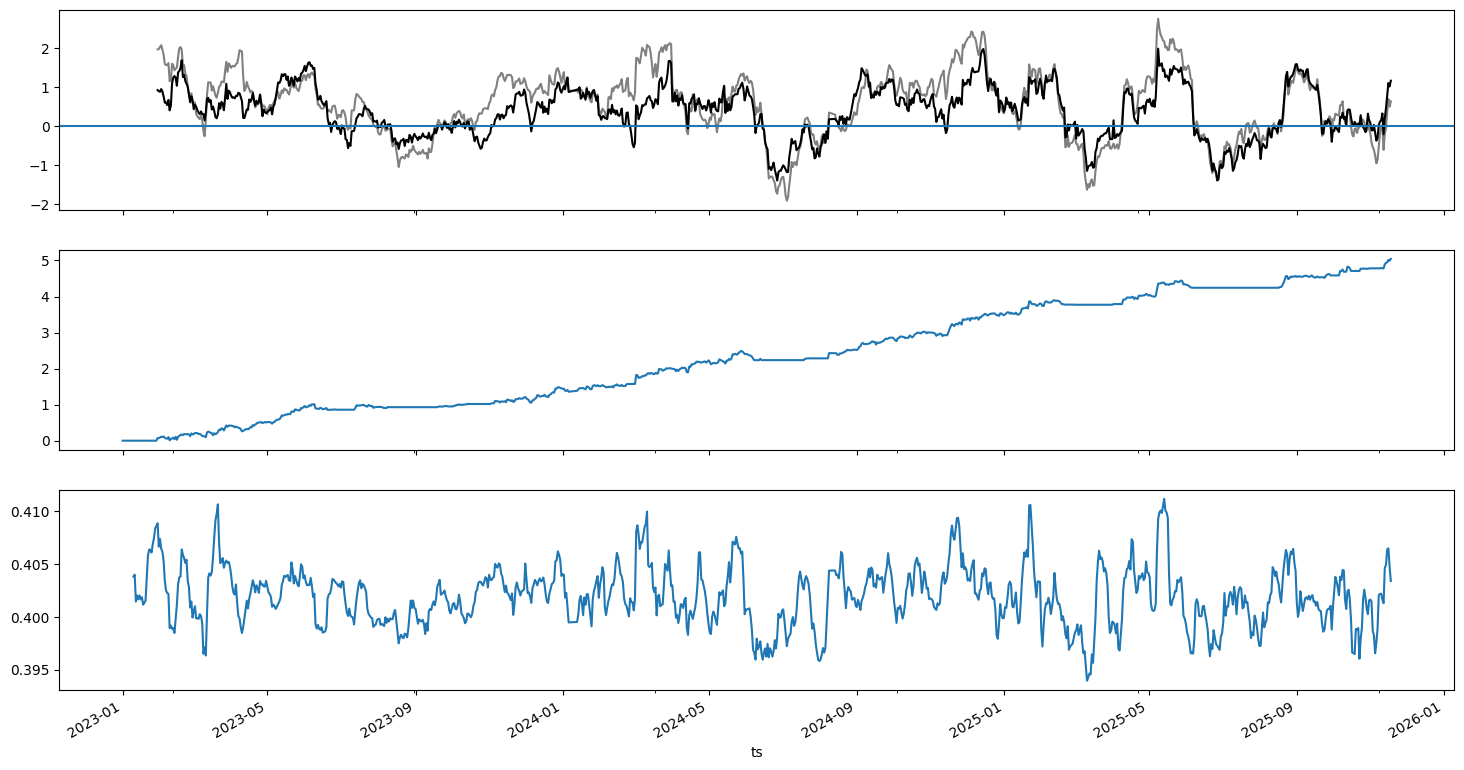

In [19]:
import matplotlib.pyplot as plt
import numpy as np

df = con.sql('''
select
    c.ts,
    c.symbol,
    c.mom1d,
    c.mom30d,
    c.ret,
    c.vol,
    c.vol15d,
    cc.ret as ref,
    c.run
from coins c
join coins cc on c.ts = cc.ts
where cc.symbol = 'btc' and year(c.ts) >= 2023
order by c.ts, c.symbol
''').pl()

df = df.with_columns([
    pl.col('vol15d').qcut(
        10, 
        allow_duplicates=True, 
        labels=list(map(lambda n: f'{n}', range(1,11)))
    ).over('ts').alias('volrank'),
    pl.col('mom30d').abs().qcut(
        10,
        allow_duplicates=True, 
        labels=list(map(lambda n: f'{n}', range(1,11)))
    ).over('ts').alias('longrank'),
    pl.col('mom1d').qcut(
        10, 
        allow_duplicates=True, 
        labels=list(map(lambda n: f'{n}', range(1,11)))
    ).over('ts').alias('rank'),
]).filter([
    (pl.col('volrank').is_in(['10']).not_()) & (pl.col('longrank').is_in(['8','9','10']).not_())
]).filter([
    pl.col('rank') == '1',
]).with_columns([
    (pl.col('vol') / pl.col('vol').sum().over(['ts'])).alias('weight')
]).sort(['ts','symbol']).with_columns([
    pl.col('weight').alias('initial'),
    (pl.col('weight') * pl.col('ret').exp()).alias('eod')
]).with_columns([
    ((pl.col('eod').abs() + pl.col('initial').abs()) * 0.002).alias('fee'),
]).with_columns([
    (pl.col('eod') - pl.col('initial') - pl.col('fee')).alias('pnl'),
])
  
res = df.sort('ts').group_by('ts').agg([
    (1 + pl.col('pnl').sum()).log().alias('strategy'),
    pl.col('fee').sum().alias('fee'),
    pl.col('ref').first(),
]).sort(['ts']).with_columns([
    (pl.col('strategy') - pl.col('ref')).alias('perf'),
]).with_columns([
    pl.when(
        pl.col('perf').rolling_mean(30) > 0).then(pl.col('perf')).otherwise(0).alias('cond')
]).with_columns([
    pl.col('cond').cum_sum().alias('equity'),
]).to_pandas().set_index('ts').sort_index()

fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(18,10), sharex=True)

((np.exp(res.strategy) - 1) * 100).rolling(30).mean().plot(y='strategy',ax=ax1,color='gray')
((np.exp(res.perf) - 1) * 100).rolling(30).mean().plot(y='perf',ax=ax1,color='black')
ax1.axhline(0)
res.equity.plot(y='equity',ax=ax2)
(res.fee * 100).rolling(10).mean().plot(y='fee',ax=ax3)

<Axes: xlabel='ts'>

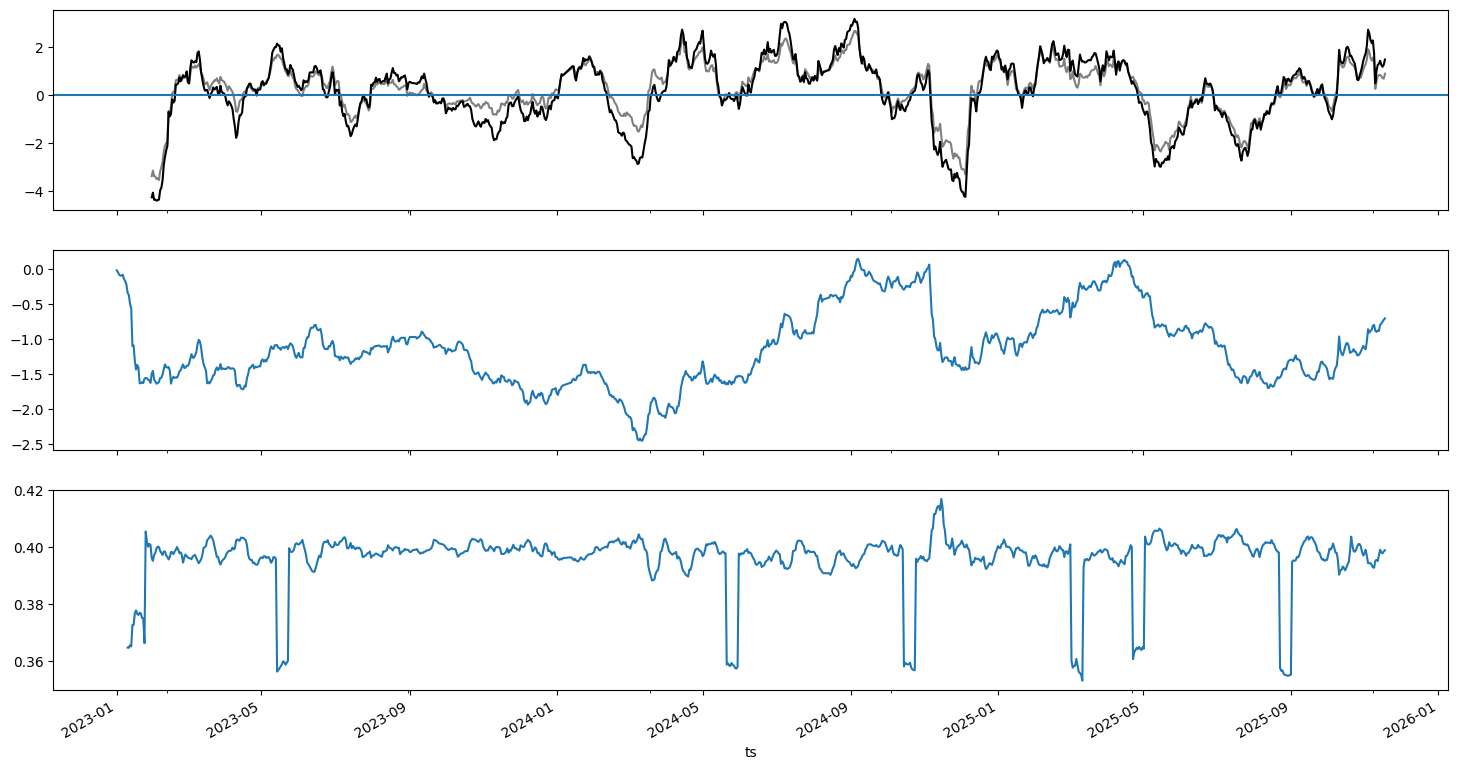

In [40]:
import matplotlib.pyplot as plt
import numpy as np

df = con.sql('''
select
    c.ts,
    c.symbol,
    c.mom1d as mom,
    c.mom5d,
    c.mom10d,
    c.mom15d,
    c.mom30d,
    c.mom60d,
    c.ret,
    c.vol,
    c.vol15d,
    cc.ret as ref,
    c.run
from coins c
join coins cc on c.ts = cc.ts
where cc.symbol = 'btc' and year(c.ts) >= 2023
order by c.ts, c.symbol
''').pl()

df = df.filter([
    #pl.col('mom') == pl.col('mom')
    #pl.col('mom').sign() == pl.col('mom60d').sign()
    pl.col('run').abs() < 3
    #(pl.col('run').sign() == pl.col('mom60d').sign())
]).with_columns([
    pl.col('vol15d').qcut(
        10, 
        allow_duplicates=True, 
        labels=list(map(lambda n: f'{n}', range(1,11)))
    ).over('ts').alias('volrank'),
    pl.col('mom').qcut(
        10, 
        allow_duplicates=True, 
        labels=list(map(lambda n: f'{n}', range(1,11)))
    ).over('ts').alias('rank'),
    pl.col('mom30d').abs().qcut(
        10,
        allow_duplicates=True, 
        labels=list(map(lambda n: f'{n}', range(1,11)))
    ).over('ts').alias('longrank'),
]).filter([
    #pl.col('mom') == pl.col('mom'),
    (pl.col('volrank').is_in(['1','2','3']))
    #(pl.col('longrank').is_in(['1','2']))
]).with_columns([
    pl.when(
        pl.col('rank').is_in(['9','8'])).then(pl.lit(-1)).when(
        pl.col('rank') == '1').then(pl.lit(0)).otherwise(
        pl.lit(0)).alias('dir'),
]).with_columns([
    (pl.col('vol') / pl.col('vol').sum().over(['ts', 'dir']) * pl.col('dir') * pl.lit(1)).alias('weight')
]).sort(['ts','symbol']).with_columns([
    pl.col('weight').alias('initial'),
    (pl.col('weight') * pl.col('ret').exp()).alias('eod')
]).with_columns([
    ((pl.col('eod').abs() + pl.col('initial').abs()) * 0.002).alias('fee'),
]).with_columns([
    (pl.col('eod') - pl.col('initial') - pl.col('fee')).alias('pnl'),
])
  
res = df.sort('ts').group_by('ts').agg([
    (1 + pl.col('pnl').sum()).log().alias('strategy'),
    pl.col('fee').sum().alias('fee'),
    pl.col('ref').first(),
]).sort(['ts']).with_columns([
    (pl.col('strategy') - pl.col('ref')).alias('perf'),
]).with_columns([
    pl.col('perf').cum_sum().alias('equity'),
]).to_pandas().set_index('ts').sort_index()

fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(18,10), sharex=True)

((np.exp(res.strategy) - 1) * 100).rolling(30).mean().plot(y='strategy',ax=ax1,color='gray')
((np.exp(res.perf) - 1) * 100).rolling(30).mean().plot(y='perf',ax=ax1,color='black')
ax1.axhline(0)
res.equity.plot(y='equity',ax=ax2)
(res.fee * 100).rolling(10).mean().plot(y='fee',ax=ax3)